In [1]:
import os, random
import matplotlib.pyplot as plt  
import numpy as np  
import matplotlib.image as mpimg  
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf  
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import warnings
from pathlib import Path
from pprint import pprint

warnings.filterwarnings("ignore")
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [2]:
# Raíz del proyecto asumida como el directorio actual del notebook
PROJECT_ROOT = Path.cwd()
dataset_path = PROJECT_ROOT / "dataset"

print("Dataset ubicado en:", dataset_path.resolve())
if not dataset_path.exists():
    raise FileNotFoundError(f"No se encontró la carpeta: {dataset_path}")

train_path = os.path.join(dataset_path, 'train')
validation_path = os.path.join(dataset_path, 'validation')
test_path = os.path.join(dataset_path, 'test')

Dataset ubicado en: C:\Users\yorka\OneDrive\Escritorio\IA2\CNN_ENFERMEDADES\dataset


In [3]:
ES_LABELS = {
    "Pepper__bell___Bacterial_spot": "Pimiento morrón – Mancha bacteriana",
    "Pepper__bell___healthy": "Pimiento morrón – Sano",
    "Potato___Early_blight": "Papa – Tizón temprano",
    "Potato___healthy": "Papa – Sano",
    "Potato___Late_blight": "Papa – Tizón tardío",
    "Tomato__Target_Spot": "Tomate – Mancha diana",
    "Tomato__Tomato_mosaic_virus": "Tomate – Virus del mosaico (ToMV)",
    "Tomato__Tomato_YellowLeaf__Curl_Virus": "Tomate – Virus del rizado amarillo (TYLCV)",
    "Tomato_Bacterial_spot": "Tomate – Mancha bacteriana",
    "Tomato_Early_blight": "Tomate – Tizón temprano",
    "Tomato_healthy": "Tomate – Sano",
    "Tomato_Late_blight": "Tomate – Tizón tardío",
    "Tomato_Leaf_Mold": "Tomate – Moho de la hoja",
    "Tomato_Septoria_leaf_spot": "Tomate – Mancha foliar por Septoria",
    "Tomato_Spider_mites_Two_spotted_spider_mite": "Tomate – Ácaros (araña de dos manchas)",
}

def es_label(folder_name: str) -> str:
    if folder_name in ES_LABELS:
        return ES_LABELS[folder_name]
    return folder_name.replace("___", " – ").replace("__", " ").replace("_", " ")


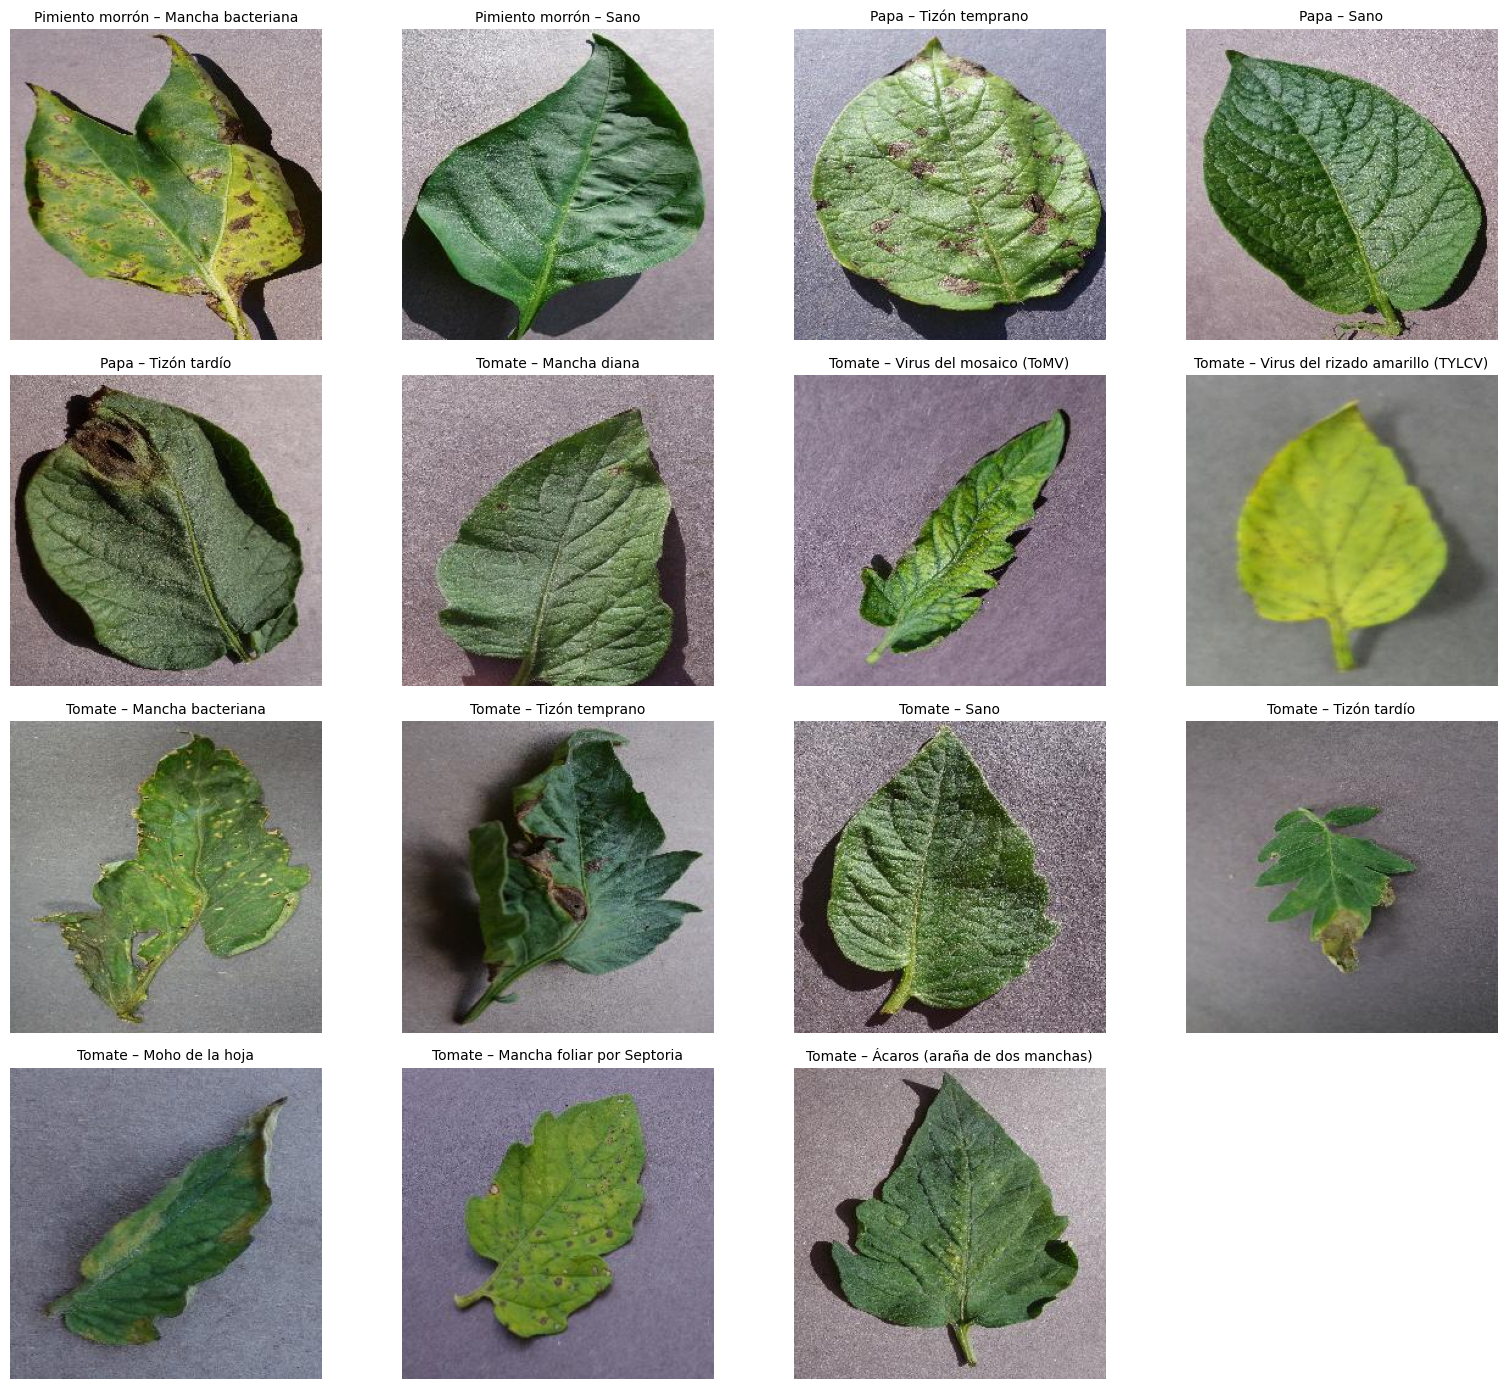

In [ ]:
# --- Config ---
SPLIT_DIR = Path("dataset/test")  
random.seed(42) 
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}
# --- Recolectar 1 imagen aleatoria por clase ---
samples = []
for item in sorted(p for p in SPLIT_DIR.iterdir() if p.is_dir()):
    imgs = [p for p in item.rglob("*") if p.suffix.lower() in IMG_EXTS]
    if not imgs:
        continue
    choice = random.choice(imgs)
    samples.append((item.name, choice))

# --- Mostrar en grilla con encabezado en español ---
n = len(samples)
cols = 4
rows = (n + cols - 1) // cols
plt.figure(figsize=(4*cols, 3.5*rows))

for i, (cls, path) in enumerate(samples, start=1):
    img = mpimg.imread(path)
    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(es_label(cls), fontsize=10)

plt.tight_layout()
plt.show()

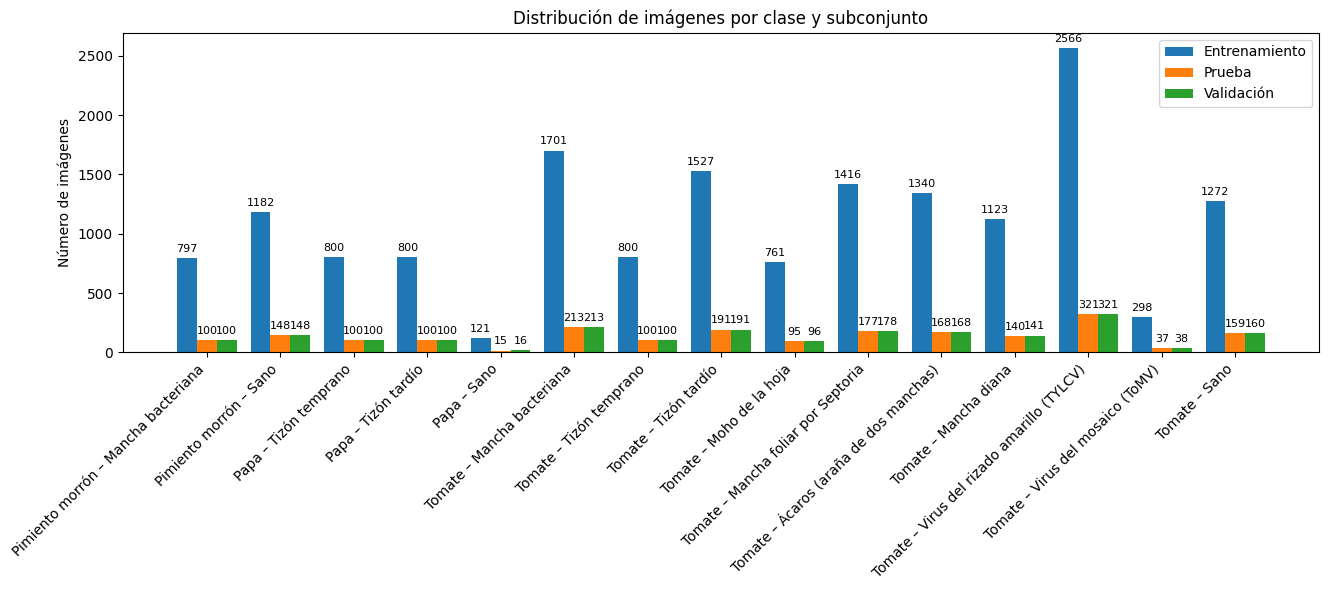

In [5]:
try:
    DATASET_ROOT = Path(dataset_path)
except NameError:
    DATASET_ROOT = Path("dataset")

SUBSETS = ["train", "test", "validation"]
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}


# 1) Recolectar conteos por subset y clase
conteos = {s: {} for s in SUBSETS}
for subset in SUBSETS:
    subset_dir = DATASET_ROOT / subset
    if not subset_dir.exists():
        # Si falta el subset, lo dejamos vacío (cero en el gráfico)
        continue
    for class_dir in sorted([p for p in subset_dir.iterdir() if p.is_dir()]):
        n_imgs = sum(1 for p in class_dir.rglob("*") if p.suffix.lower() in IMG_EXTS)
        conteos[subset][class_dir.name] = n_imgs

# 2) Unificar el conjunto de clases presentes en cualquiera de los splits
todas_las_clases = sorted(set().union(*[set(conteos[s].keys()) for s in SUBSETS]))

# 3) Preparar vectores alineados (cero si una clase no aparece en un split)
train_counts = [conteos["train"].get(c, 0) for c in todas_las_clases]
test_counts  = [conteos["test"].get(c, 0) for c in todas_las_clases]
val_counts   = [conteos["validation"].get(c, 0) for c in todas_las_clases]

labels_es = [es_label(c) for c in todas_las_clases]

# 4) Gráfico de barras agrupadas (en español)
x = np.arange(len(todas_las_clases))
width = 0.27

fig, ax = plt.subplots(figsize=(max(10, len(todas_las_clases)*0.9), 6))
r1 = ax.bar(x - width, train_counts, width, label='Entrenamiento')
r2 = ax.bar(x,          test_counts,  width, label='Prueba')
r3 = ax.bar(x + width,  val_counts,   width, label='Validación')

ax.set_ylabel('Número de imágenes')
ax.set_title('Distribución de imágenes por clase y subconjunto')
ax.set_xticks(x)
ax.set_xticklabels(labels_es, rotation=45, ha='right')
ax.legend()

# (Opcional) Anotar los conteos arriba de cada barra
def autolabel(bars):
    for b in bars:
        h = b.get_height()
        if h > 0:
            ax.annotate(f'{int(h)}', xy=(b.get_x() + b.get_width()/2, h),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
autolabel(r1); autolabel(r2); autolabel(r3)

plt.tight_layout()
plt.show()



In [6]:
batch_size = 32
image_shape = (256, 256)

# Aumento de datos más agresivo para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1/255,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode="categorical"
)

validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print(f"Clases encontradas: {len(train_generator.class_indices)}")
print(f"Imágenes de entrenamiento: {train_generator.samples}")
print(f"Imágenes de validación: {validation_generator.samples}")
print(f"Imágenes de prueba: {test_generator.samples}")

Found 16504 images belonging to 15 classes.
Found 2070 images belonging to 15 classes.
Found 2064 images belonging to 15 classes.
Clases encontradas: 15
Imágenes de entrenamiento: 16504
Imágenes de validación: 2070
Imágenes de prueba: 2064


In [7]:
model = Sequential([
    # Bloque 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Bloque 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Bloque 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Bloque 4
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Capa densa
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(15, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,225,039 (50.45 MB)

 Trainable params: 13,223,311 (50.44 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [8]:
checkpoint_callback = ModelCheckpoint(
    "best_epoch_weights.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [9]:
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback, early_stopping, reduce_lr]
)

best_epoch = np.argmax(history.history['val_accuracy']) + 1
print(f"\n🎯 Mejor época: {best_epoch}")

Epoch 1/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4541 - loss: 1.7908
Epoch 1: val_accuracy improved from None to 0.32715, saving model to best_epoch_weights.keras
515/515 ━━━━━━━━━━━━━━━━━━━━ 887s 2s/step - accuracy: 0.5521 - loss: 1.4100 - val_accuracy: 0.3271 - val_loss: 3.7454 - learning_rate: 0.0010
Epoch 2/50
  1/515 ━━━━━━━━━━━━━━━━━━━━ 14:02 2s/step - accuracy: 0.4688 - loss: 2.0449
Epoch 2: val_accuracy did not improve from 0.32715
515/515 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.4688 - loss: 2.0449 - val_accuracy: 0.3193 - val_loss: 3.7163 - learning_rate: 0.0010
Epoch 3/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6683 - loss: 0.9957
Epoch 3: val_accuracy improved from 0.32715 to 0.64160, saving model to best_epoch_weights.keras
515/515 ━━━━━━━━━━━━━━━━━━━━ 893s 2s/step - accuracy: 0.6938 - loss: 0.9162 - val_accuracy: 0.6416 - val_loss: 1.1360 - learning_rate: 0.0010
Epoch 4/50
  1/515 ━━━━━━━━━━━━━━━━━━━━ 14:10 2s/step - accuracy: 0.7188 

In [10]:
best_model = model
best_model.load_weights("best_epoch_weights.keras")
best_model.save("modelo_multiple_enfermedades_hojas_de_plantas.keras")
print("✅ Modelo guardado exitosamente")

✅ Modelo guardado exitosamente


In [11]:
evaluation = best_model.evaluate(test_generator, verbose=1)
print(f"\n📊 RESULTADOS EN TEST:")
print(f"   Exactitud: {round(evaluation[1] * 100, 2)}%")
print(f"   Pérdida: {round(evaluation[0], 4)}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - accuracy: 0.9709 - loss: 0.0906

📊 RESULTADOS EN TEST:
   Exactitud: 97.09%
   Pérdida: 0.0906


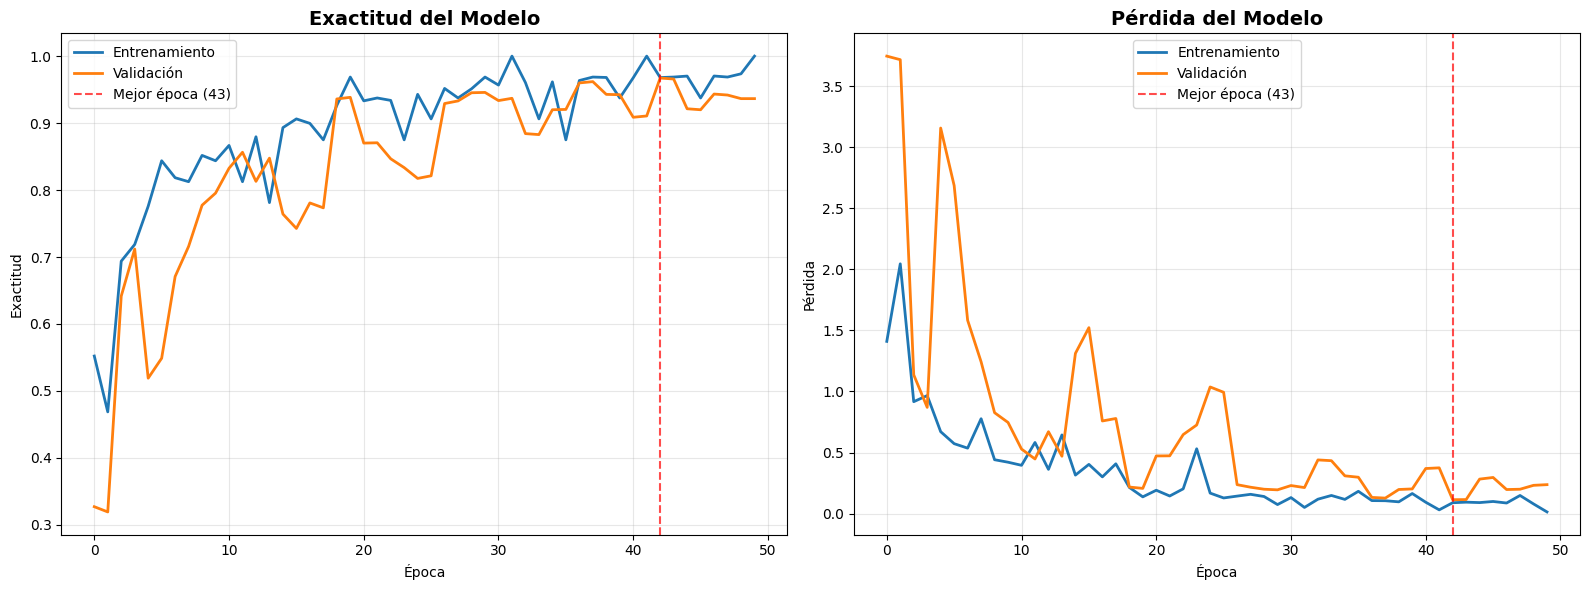

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Exactitud
ax1.plot(history.history['accuracy'], label='Entrenamiento', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validación', linewidth=2)
ax1.axvline(x=best_epoch-1, color='red', linestyle='--', alpha=0.7, label=f'Mejor época ({best_epoch})')
ax1.set_title('Exactitud del Modelo', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Exactitud')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Pérdida
ax2.plot(history.history['loss'], label='Entrenamiento', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validación', linewidth=2)
ax2.axvline(x=best_epoch-1, color='red', linestyle='--', alpha=0.7, label=f'Mejor época ({best_epoch})')
ax2.set_title('Pérdida del Modelo', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Pérdida')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


ANÁLISIS DETALLADO DEL MODELO
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step


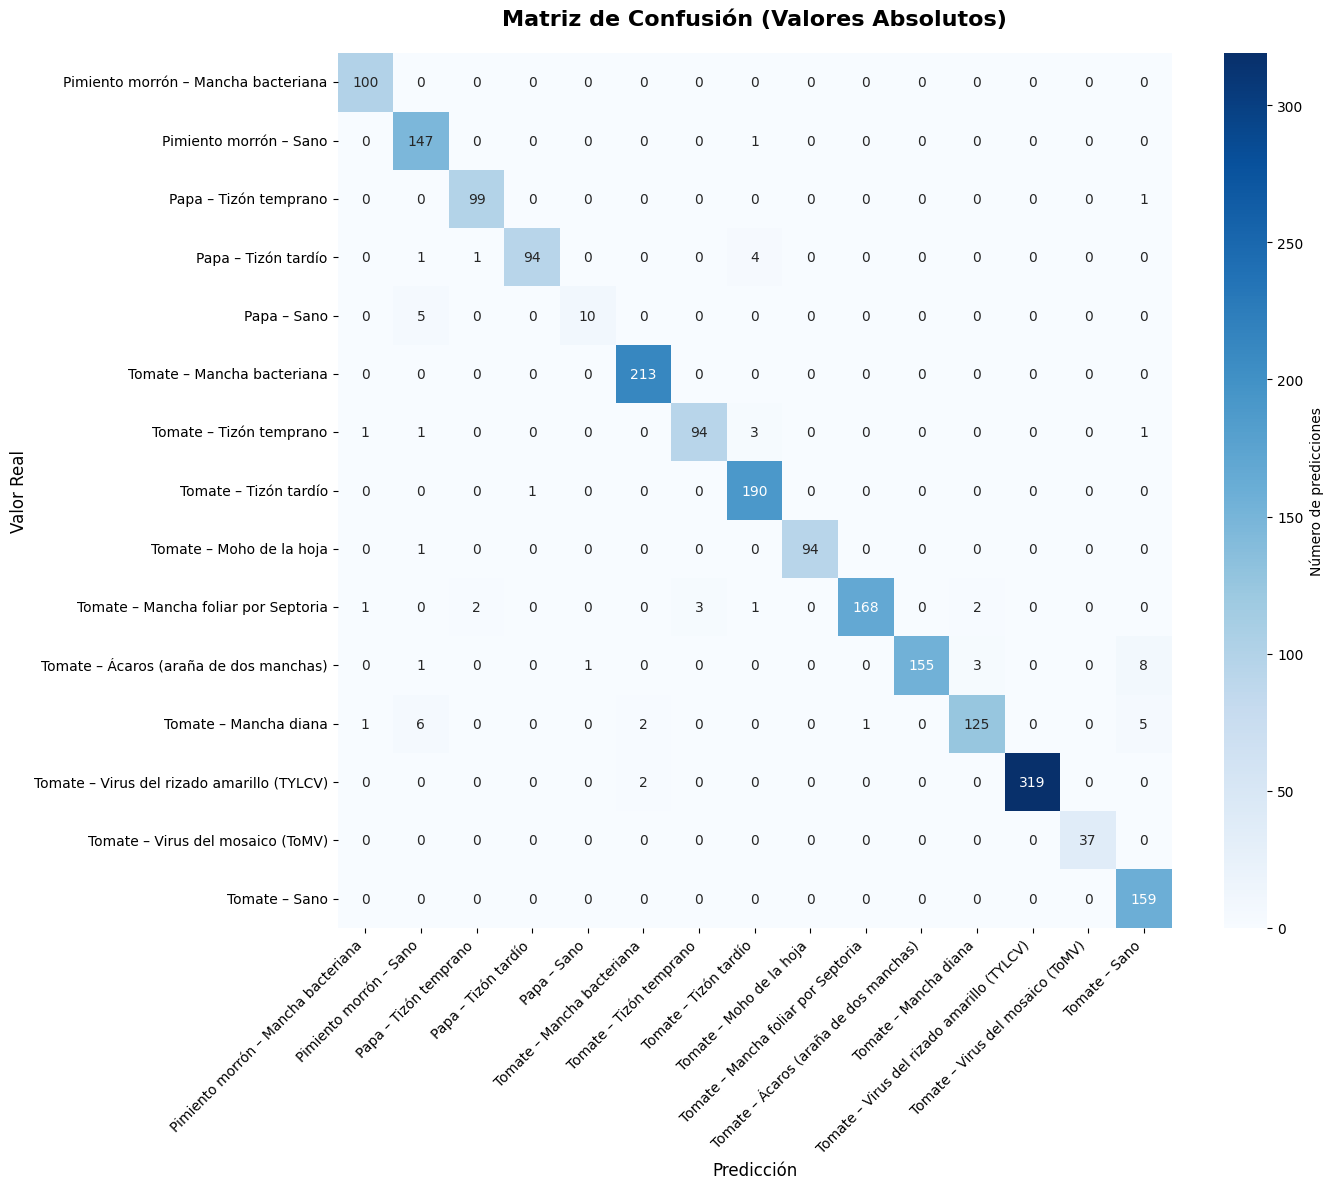

In [13]:
print("\n" + "="*60)
print("ANÁLISIS DETALLADO DEL MODELO")
print("="*60)

# Obtener predicciones
test_generator.reset()
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
y_prob = best_model.predict(test_generator, steps=steps, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

# Nombres de clases
class_names = list(test_generator.class_indices.keys())
class_names_es = [es_label(cn) for cn in class_names]

# 1. Matriz de Confusión Absoluta
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names_es, yticklabels=class_names_es,
            cbar_kws={'label': 'Número de predicciones'})
plt.title('Matriz de Confusión (Valores Absolutos)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()




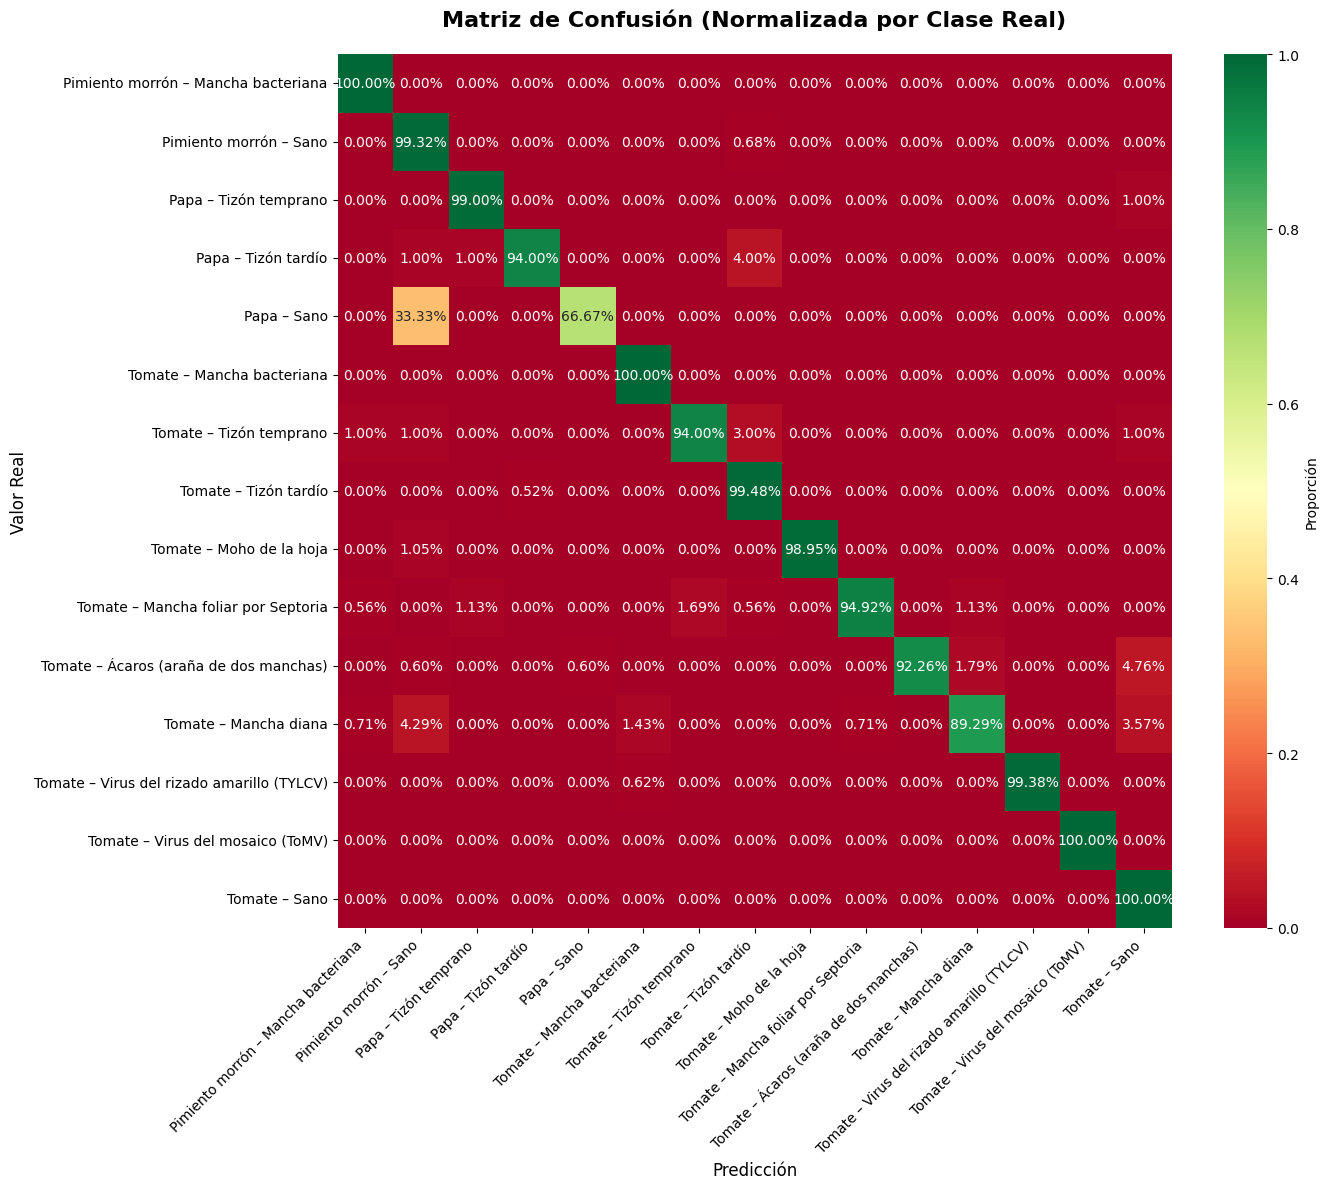


📈 MÉTRICAS GLOBALES:
   Exactitud Global: 0.9709 (97.09%)

   Promedios Macro:
      Precisión: 0.9682
      Recall: 0.9515
      F1-Score: 0.9580

   Promedios Ponderados:
      Precisión: 0.9720
      Recall: 0.9709
      F1-Score: 0.9707


In [14]:
# 2. Matriz de Confusión Normalizada
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=class_names_es, yticklabels=class_names_es,
            vmin=0, vmax=1, cbar_kws={'label': 'Proporción'})
plt.title('Matriz de Confusión (Normalizada por Clase Real)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Métricas Globales
print("\n📈 MÉTRICAS GLOBALES:")
print(f"   Exactitud Global: {accuracy_score(y_true, y_pred):.4f} ({accuracy_score(y_true, y_pred)*100:.2f}%)")

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f"\n   Promedios Macro:")
print(f"      Precisión: {precision_macro:.4f}")
print(f"      Recall: {recall_macro:.4f}")
print(f"      F1-Score: {f1_macro:.4f}")

print(f"\n   Promedios Ponderados:")
print(f"      Precisión: {precision_weighted:.4f}")
print(f"      Recall: {recall_weighted:.4f}")
print(f"      F1-Score: {f1_weighted:.4f}")

In [15]:
# 4. Reporte de Clasificación Detallado
print("\n" + "="*60)
print("REPORTE DE CLASIFICACIÓN POR CLASE")
print("="*60)
report = classification_report(y_true, y_pred, target_names=class_names_es, digits=4)
print(report)

# 5. Análisis por Clase (Top y Bottom performers)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
metrics_df = []
for i, clase in enumerate(class_names_es):
    metrics_df.append({
        'Clase': clase,
        'Precisión': precision[i],
        'Recall': recall[i],
        'F1-Score': f1[i],
        'Soporte': support[i]
    })

metrics_df = sorted(metrics_df, key=lambda x: x['F1-Score'], reverse=True)

print("\n🏆 TOP 5 CLASES CON MEJOR DESEMPEÑO (F1-Score):")
for i, m in enumerate(metrics_df[:5], 1):
    print(f"   {i}. {m['Clase']}")
    print(f"      F1: {m['F1-Score']:.4f} | Precisión: {m['Precisión']:.4f} | Recall: {m['Recall']:.4f} | Muestras: {m['Soporte']}")

print("\n⚠️  TOP 5 CLASES CON PEOR DESEMPEÑO (F1-Score):")
for i, m in enumerate(metrics_df[-5:], 1):
    print(f"   {i}. {m['Clase']}")
    print(f"      F1: {m['F1-Score']:.4f} | Precisión: {m['Precisión']:.4f} | Recall: {m['Recall']:.4f} | Muestras: {m['Soporte']}")


REPORTE DE CLASIFICACIÓN POR CLASE
                                            precision    recall  f1-score   support

       Pimiento morrón – Mancha bacteriana     0.9709    1.0000    0.9852       100
                    Pimiento morrón – Sano     0.9074    0.9932    0.9484       148
                     Papa – Tizón temprano     0.9706    0.9900    0.9802       100
                       Papa – Tizón tardío     0.9895    0.9400    0.9641       100
                               Papa – Sano     0.9091    0.6667    0.7692        15
                Tomate – Mancha bacteriana     0.9816    1.0000    0.9907       213
                   Tomate – Tizón temprano     0.9691    0.9400    0.9543       100
                     Tomate – Tizón tardío     0.9548    0.9948    0.9744       191
                  Tomate – Moho de la hoja     1.0000    0.9895    0.9947        95
       Tomate – Mancha foliar por Septoria     0.9941    0.9492    0.9711       177
    Tomate – Ácaros (araña de dos manch

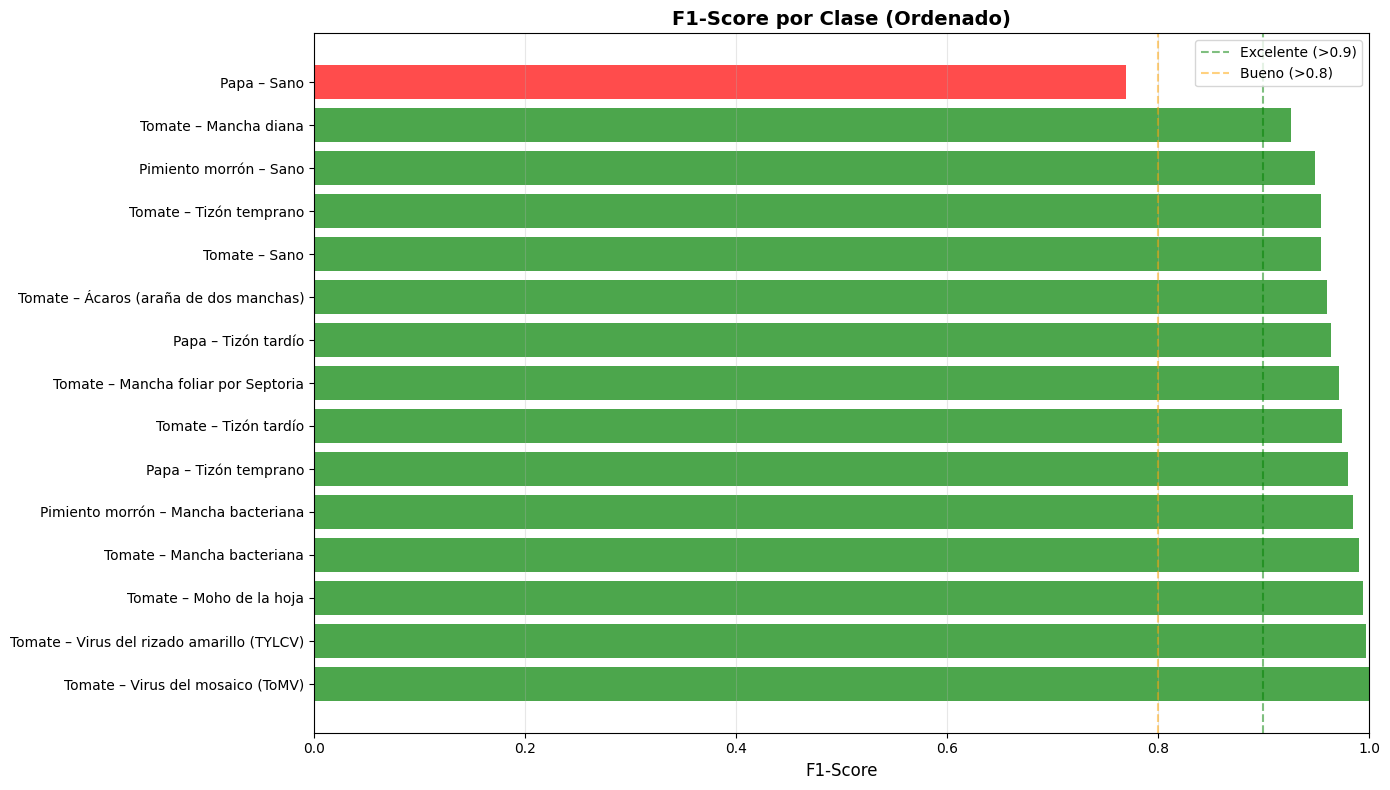

In [16]:
#6. Gráfico de Barras de F1-Score por Clase
fig, ax = plt.subplots(figsize=(14, 8))
clases_sorted = [m['Clase'] for m in metrics_df]
f1_sorted = [m['F1-Score'] for m in metrics_df]
colors = ['green' if f1 > 0.9 else 'orange' if f1 > 0.8 else 'red' for f1 in f1_sorted]

bars = ax.barh(clases_sorted, f1_sorted, color=colors, alpha=0.7)
ax.set_xlabel('F1-Score', fontsize=12)
ax.set_title('F1-Score por Clase (Ordenado)', fontsize=14, fontweight='bold')
ax.axvline(x=0.9, color='green', linestyle='--', alpha=0.5, label='Excelente (>0.9)')
ax.axvline(x=0.8, color='orange', linestyle='--', alpha=0.5, label='Bueno (>0.8)')
ax.set_xlim(0, 1.0)
ax.legend()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
def predecir_imagen(ruta_imagen, modelo, mostrar=True):
    """
    Predice la clase de una imagen individual y muestra el resultado.
    
    Args:
        ruta_imagen: Ruta a la imagen
        modelo: Modelo entrenado
        mostrar: Si True, muestra la imagen con la predicción
    
    Returns:
        dict con información de la predicción
    """
    # Cargar y preprocesar imagen
    img = load_img(ruta_imagen, target_size=image_shape)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predicción
    prediccion = modelo.predict(img_array, verbose=0)
    clase_pred_idx = np.argmax(prediccion[0])
    confianza = prediccion[0][clase_pred_idx]
    
    # Obtener nombres
    clase_pred_nombre = class_names[clase_pred_idx]
    clase_pred_es = es_label(clase_pred_nombre)
    
    # Top 3 predicciones
    top3_idx = np.argsort(prediccion[0])[-3:][::-1]
    top3 = [(class_names[i], es_label(class_names[i]), prediccion[0][i]) for i in top3_idx]
    
    if mostrar:
        plt.figure(figsize=(12, 5))
        
        # Mostrar imagen
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Predicción: {clase_pred_es}\nConfianza: {confianza*100:.2f}%', 
                  fontsize=12, fontweight='bold')
        
        # Gráfico de barras con probabilidades
        plt.subplot(1, 2, 2)
        nombres = [t[1][:30] for t in top3]  # Truncar nombres largos
        confianzas = [t[2]*100 for t in top3]
        colors_bar = ['green' if i == 0 else 'orange' if i == 1 else 'gray' for i in range(3)]
        
        plt.barh(nombres, confianzas, color=colors_bar, alpha=0.7)
        plt.xlabel('Confianza (%)')
        plt.title('Top 3 Predicciones', fontsize=12, fontweight='bold')
        plt.xlim(0, 100)
        plt.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'clase_predicha': clase_pred_nombre,
        'clase_predicha_es': clase_pred_es,
        'confianza': confianza,
        'top3': top3,
        'todas_probabilidades': prediccion[0]
    }



🖼️  Prediciendo imagen específica...


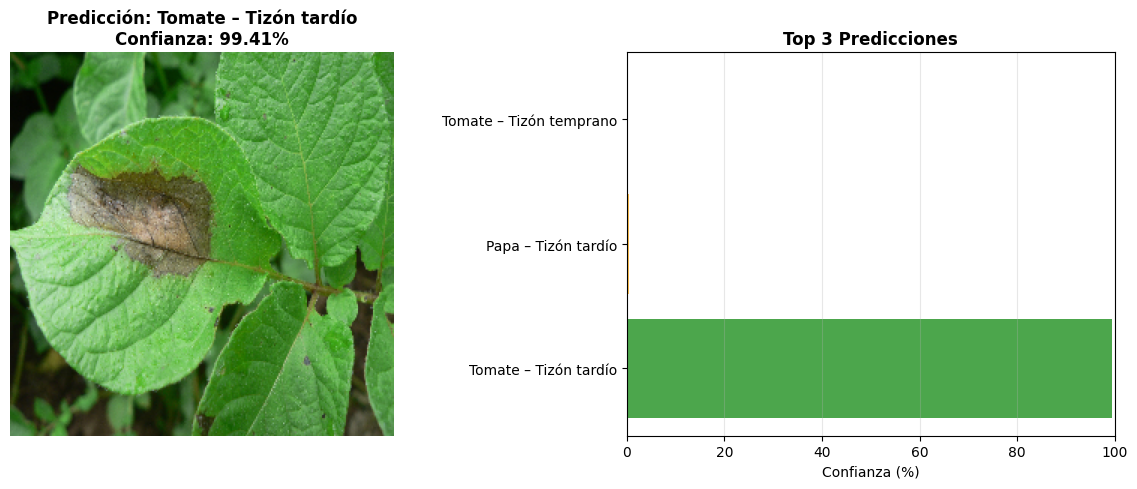


✅ Análisis completo finalizado


In [19]:

# Opción 2: Predecir una imagen específica (descomenta y ajusta la ruta)
print("\n🖼️  Prediciendo imagen específica...")
ruta_mi_imagen = "papa.jpg"
resultado = predecir_imagen(ruta_mi_imagen, best_model, mostrar=True)

print("\n✅ Análisis completo finalizado")


🖼️  Prediciendo imagen específica...


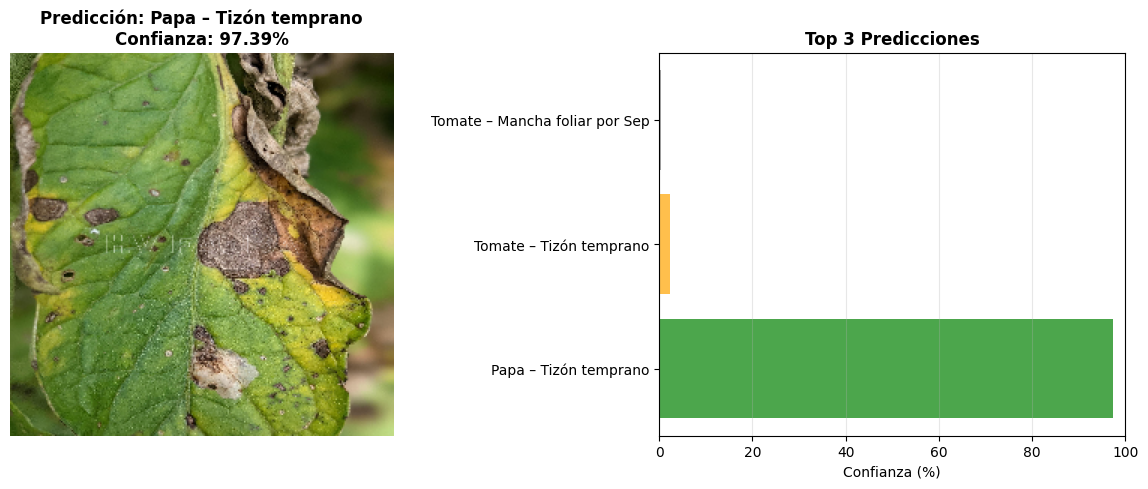


✅ Análisis completo finalizado


In [23]:
# Opción 2: Predecir una imagen específica (descomenta y ajusta la ruta)
print("\n🖼️  Prediciendo imagen específica...")
ruta_mi_imagen = "papa2.jpeg"
resultado = predecir_imagen(ruta_mi_imagen, best_model, mostrar=True)

print("\n✅ Análisis completo finalizado")


🖼️  Prediciendo imagen específica...


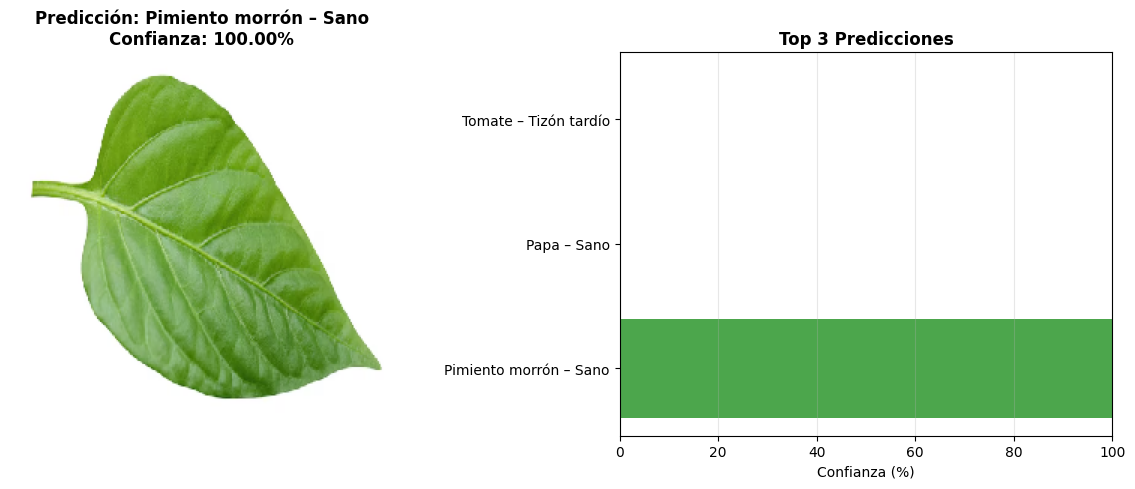


✅ Análisis completo finalizado


In [26]:
# Opción 2: Predecir una imagen específica (descomenta y ajusta la ruta)
print("\n🖼️  Prediciendo imagen específica...")
ruta_mi_imagen = "pimenton.jpg"
resultado = predecir_imagen(ruta_mi_imagen, best_model, mostrar=True)

print("\n✅ Análisis completo finalizado")


🖼️  Prediciendo imagen específica...


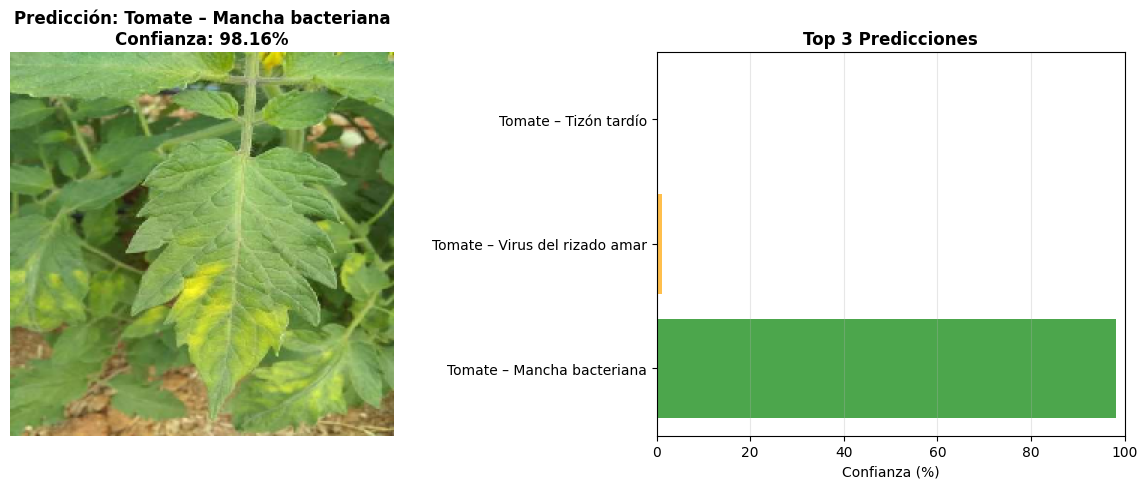


✅ Análisis completo finalizado


In [30]:
# Opción 2: Predecir una imagen específica (descomenta y ajusta la ruta)
print("\n🖼️  Prediciendo imagen específica...")
ruta_mi_imagen = "tomate.png"
resultado = predecir_imagen(ruta_mi_imagen, best_model, mostrar=True)

print("\n✅ Análisis completo finalizado")